In [1]:
%load_ext watermark
%watermark -a 'Niko' -v -p torch

Author: Niko

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.31.0

torch: 1.10.0



### Basic Graph Neural Network with Edge Prediction on MNIST

A very basic neural network (GNN) implementation using a subnetwork for edge prediction.

<br>Here, the $28$ x $28$ image of a digit in MNIST represents the graph, where each pixel (i.e., cell in the grid) represents a particular node. The feature of that node is simply the pixel intensity in range $[0, 1]$.

<br>The adjacency matrix of the pixels was basically just determined by the neighborhood pixels. Using a Gaussian filter, pixels were connected based on their Euclidean distance in grid. In this notebook, the edges are predicted via a seperate neural network model.

<br>
self.pred_edge_fc = nn.Sequential(nn.Linear(coord_features, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 1),
                                    nn.Tanh())

<br>Using the resulting adjacency matrix $A$, we can compute the output of a layer as
\begin{align*}
X^{(l+1)} = AX^{(l)}W^{(l)}
\end{align*}

<br>Here, $A$ is the $N$ x $N$ adjacency matrix, and $X$ is the $N$ x $C$ feature matrix (a 2D coordinate array, where $N$ is the total number of pixels -- $28$ x $28$ $=784$ in MNIST). $W$ is the weight matrix of shape $N$ x $P$, where $P$ would represent the number of classes if we have only a single hidden layer.



In [2]:
# Import libraries
import time, torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

%matplotlib inline

In [3]:
# Setting device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setting hyper-parameters
RANDOM_SEED = 42
LAERNING_RATE = 0.0005
NUM_EPOCHS = 5
BATCH_SIZE = 128
IMG_SIZE = 28

### MNIST Dataset

In [4]:
custom_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=custom_transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=custom_transform, download=True)

In [5]:
# mean, std = torch.zeros(3), torch.zeros(3)
# for img, label in train_dataset:
#     mean += torch.mean(img, dim=(1, 2))
#     std  += torch.std(img, dim=(1, 2))

# mean /= len(train_dataset)
# std  /= len(train_dataset)

In [6]:
SPLIT_RATIO = 0.9 # 90% for training, 10% for valid
train_samples_num = int(len(train_dataset) * SPLIT_RATIO)
val_samples_num = len(train_dataset) - train_samples_num

train_dataset, val_dataset = random_split(train_dataset, [train_samples_num, val_samples_num])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

# Check the dataset
for images, labels in train_loader:
    print('Image batch dimension: ', images.shape)
    print('Image label dimension: ', labels.shape)
    break

Image batch dimension:  torch.Size([128, 1, 28, 28])
Image label dimension:  torch.Size([128])


### Building Model

In [7]:
def make_coordinate_array(img_size, out_size=4):
    # Make 2D coordinate array (for MNIST 784x2)
    n_rows = img_size * img_size
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    coord = np.stack((col, row), axis=2).reshape(-1, 2)
    coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
    coord = torch.from_numpy(coord).float()

    # Reshape to [N, N, out_size]
    coord = torch.cat((coord.unsqueeze(0).repeat(n_rows, 1, int(out_size/2-1)), 
                        coord.unsqueeze(1).repeat(1, n_rows, 1)), dim=2)
    return coord

In [8]:
# Graph Model

class GraphNet(nn.Module):
    def __init__(self, img_size=28, coord_features=4, num_classes=10):
        super(GraphNet, self).__init__()

        n_rows = img_size**2
        self.fc = nn.Linear(n_rows, num_classes, bias=False)
        coord = make_coordinate_array(img_size, coord_features)
        self.register_buffer('coord', coord)

        # Edge Predictor
        self.pred_edge_fc = nn.Sequential(nn.Linear(coord_features, 32),
                                            nn.ReLU(),
                                            nn.Linear(32, 1),
                                            nn.Tanh())

    def forward(self, x):
        B = x.size(0)

        # Predict edges
        self.A = self.pred_edge_fc(self.coord).squeeze()

        # Reshape Adjacency Matrix
        # [N, N] Adjacency Matrix -> [1, N, N] Adjacency tensor where N = H x W
        A_tensor = self.A.unsqueeze(0)
        A_tensor = A_tensor.expand(B, -1, -1) # Bx784x784

        # Reshape inputs
        # [B, C, H, W] -> [B, HxW, 1]
        x_reshape = x.view(B, -1, 1) # Bx784x1

        # bmm: batch matrix product to sum the neighbor features
        # Input: [B, N, N] x [B, N, 1]
        # Output: [B, N]
        avg_neighbor_features = torch.bmm(A_tensor, x_reshape).view(B, -1) # Bx784
        logits = self.fc(avg_neighbor_features)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [9]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=10)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

In [11]:
def compute_acc(model, dataloader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in dataloader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, pred_labels = torch.max(probas, 1)
        num_examples += features.size(0)
        correct_pred += (pred_labels == targets).sum()
    return correct_pred.float() / num_examples * 100

In [12]:
start_time = time.time()

loss_list = []
train_acc_list, val_acc_list, test_acc_list = [], [], []

for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets  = targets.to(DEVICE)

        # Forward and back-propagation
        logits, probas = model(features)
        loss = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        loss.backward()

        # Update model parameters
        optimizer.step()
        loss_list.append(loss.item())

        if not batch_idx % 150:
            print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} |"
                    f"Batch: {batch_idx:03d}/{len(train_loader):03d} |"
                    f"Loss: {loss:.4f}")
    model.eval()
    with torch.no_grad():
        train_acc = compute_acc(model, train_loader, DEVICE)
        val_acc   = compute_acc(model, val_loader, DEVICE)
        test_acc  = compute_acc(model, test_loader, DEVICE)

        print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n"
                f"Train Accuracy: {train_acc:.2f} | Valid Accuracy: {val_acc:.2f} | Test Accuracy: {test_acc:.2f}")

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)

    elapsed = (time.time() - start_time) / 60
    print(f"Time elapsed: {elapsed:.2f} min")

elapsed = (time.time() - start_time) / 60
print(f"Total Training Time: {elapsed:.2f} min") 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 001/005 |Batch: 000/422 |Loss: 27.5101
Epoch: 001/005 |Batch: 150/422 |Loss: 1.8279
Epoch: 001/005 |Batch: 300/422 |Loss: 1.3385


 20%|██        | 1/5 [01:09<04:37, 69.33s/it]

Epoch: 001/005
Train Accuracy: 67.30 | Valid Accuracy: 67.30 | Test Accuracy: 68.70
Time elapsed: 1.16 min
Epoch: 002/005 |Batch: 000/422 |Loss: 1.1985
Epoch: 002/005 |Batch: 150/422 |Loss: 1.0058
Epoch: 002/005 |Batch: 300/422 |Loss: 0.8050


 40%|████      | 2/5 [02:17<03:26, 68.86s/it]

Epoch: 002/005
Train Accuracy: 74.83 | Valid Accuracy: 74.88 | Test Accuracy: 75.57
Time elapsed: 2.30 min
Epoch: 003/005 |Batch: 000/422 |Loss: 0.8949
Epoch: 003/005 |Batch: 150/422 |Loss: 0.7578
Epoch: 003/005 |Batch: 300/422 |Loss: 0.6695


 60%|██████    | 3/5 [03:26<02:17, 68.92s/it]

Epoch: 003/005
Train Accuracy: 78.89 | Valid Accuracy: 78.78 | Test Accuracy: 79.63
Time elapsed: 3.45 min
Epoch: 004/005 |Batch: 000/422 |Loss: 0.5296
Epoch: 004/005 |Batch: 150/422 |Loss: 0.5819
Epoch: 004/005 |Batch: 300/422 |Loss: 0.6141


 80%|████████  | 4/5 [04:36<01:09, 69.10s/it]

Epoch: 004/005
Train Accuracy: 82.06 | Valid Accuracy: 81.52 | Test Accuracy: 83.24
Time elapsed: 4.60 min
Epoch: 005/005 |Batch: 000/422 |Loss: 0.5089
Epoch: 005/005 |Batch: 150/422 |Loss: 0.6041
Epoch: 005/005 |Batch: 300/422 |Loss: 0.5946


100%|██████████| 5/5 [05:35<00:00, 67.05s/it]

Epoch: 005/005
Train Accuracy: 84.82 | Valid Accuracy: 84.27 | Test Accuracy: 85.79
Time elapsed: 5.59 min
Total Training Time: 5.59 min


### Evaluation

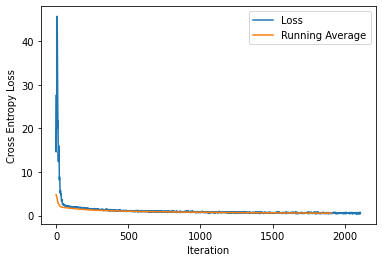

In [13]:
plt.plot(loss_list, label='Loss')
plt.plot(np.convolve(loss_list, np.ones(200,) / 200, mode='valid'), label='Running Average')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()


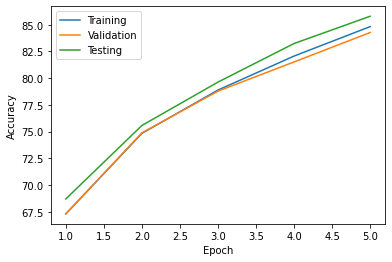

In [14]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), val_acc_list, label='Validation')
plt.plot(np.arange(1, NUM_EPOCHS+1), test_acc_list, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

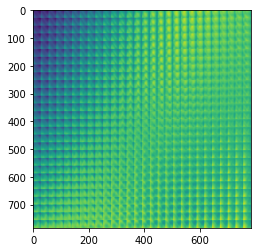

In [15]:
plt.imshow(model.A.cpu().detach().numpy())
plt.show()